<a href="https://colab.research.google.com/github/Dr-Isam-ALJAWARNEH/fds-project-geoairmob/blob/partA/GEOCODE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Load All Datasets from GitHub**


In [ ]:
%matplotlib inline

✅ Datasets loaded:
Mobility: (7785, 16)
OpenAQ: (88000, 15)
Ericsson: (12, 15)
Landsat: (6265, 79)


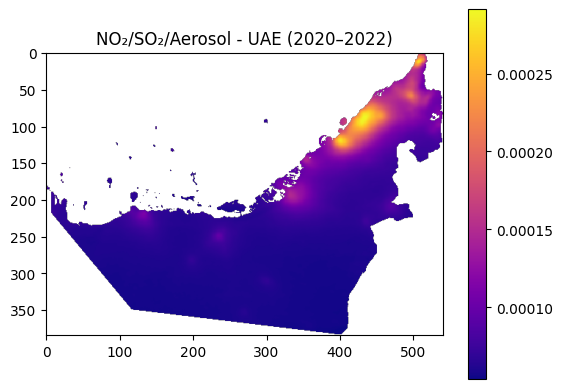

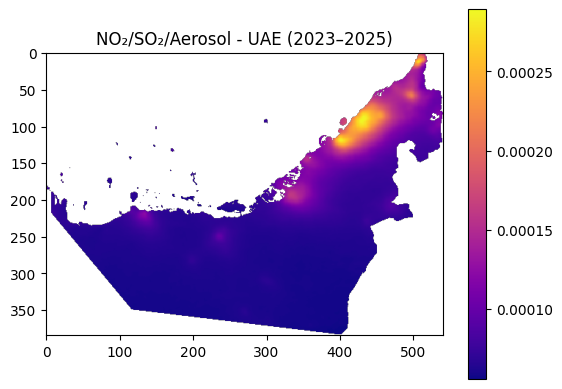

Identical arrays? False
Mean absolute difference: nan


In [ ]:
# Step 0: Install rasterio
!pip install rasterio

# Step 1: Import libraries
import pandas as pd
import rasterio
import matplotlib.pyplot as plt
import numpy as np

# Step 2: Define GitHub raw base URL
base_url = "https://raw.githubusercontent.com/Dr-Isam-ALJAWARNEH/fds-project-geoairmob/main/Datasets/"

# Step 3: Load CSV datasets
mobility_df = pd.read_csv(base_url + "AE_Region_Mobility_Report_2020_2022_combined.csv")
openaq_df = pd.read_csv(base_url + "combined_openaq_measurements.csv")
ericsson_df = pd.read_csv(base_url + "Merged_Ericsson_Mobility_Data.csv")
landsat_df = pd.read_csv(base_url + "Landsat_SRTM_Merged_Metadata.csv")

print("✅ Datasets loaded:")
print("Mobility:", mobility_df.shape)
print("OpenAQ:", openaq_df.shape)
print("Ericsson:", ericsson_df.shape)
print("Landsat:", landsat_df.shape)

# Step 4: Visualize raster
tif_url = "/vsicurl/https://github.com/Dr-Isam-ALJAWARNEH/fds-project-geoairmob/raw/main/Datasets/UAE_NO2_SO2_Aerosol_Combined_2020_2022.tif"
tif_url2= "/vsicurl/https://github.com/Dr-Isam-ALJAWARNEH/fds-project-geoairmob/raw/main/Datasets/UAE_NO2_SO2_Aerosol_Combined_2023_2025.tif"
with rasterio.open(tif_url) as src:
    img = src.read(1)
    plt.imshow(img, cmap='plasma')
    plt.title("NO₂/SO₂/Aerosol - UAE (2020–2022)")
    plt.colorbar()
    plt.show()

with rasterio.open(tif_url2) as src:
    img = src.read(1)
    plt.imshow(img, cmap='plasma')
    plt.title("NO₂/SO₂/Aerosol - UAE (2023–2025)")
    plt.colorbar()
    plt.show()


with rasterio.open(tif_url) as src1, rasterio.open(tif_url2) as src2:
    img1 = src1.read(1)
    img2 = src2.read(1)

# Are they bit-for-bit identical?
print("Identical arrays?", np.array_equal(img1, img2))

# How big is the overall difference?
print("Mean absolute difference:", np.mean(np.abs(img2 - img1)))

In [ ]:
# Compute raw difference
diff = img2 - img1

# Create a mask of only the finite (non-NaN) locations
valid_mask = np.isfinite(diff)

# Now compute stats on just those pixels
mean_abs_diff = np.mean(np.abs(diff[valid_mask]))
max_abs_diff  = np.max(np.abs(diff[valid_mask]))
num_changed   = np.count_nonzero(diff[valid_mask] != 0)

print("Mean absolute difference (valid pixels):", mean_abs_diff)
print("Max absolute difference (valid pixels):",  max_abs_diff)
print("Number of pixels that differ:",           num_changed)

Mean absolute difference (valid pixels): 3.08734567172e-06
Max absolute difference (valid pixels): 2.5927557503e-05
Number of pixels that differ: 80422


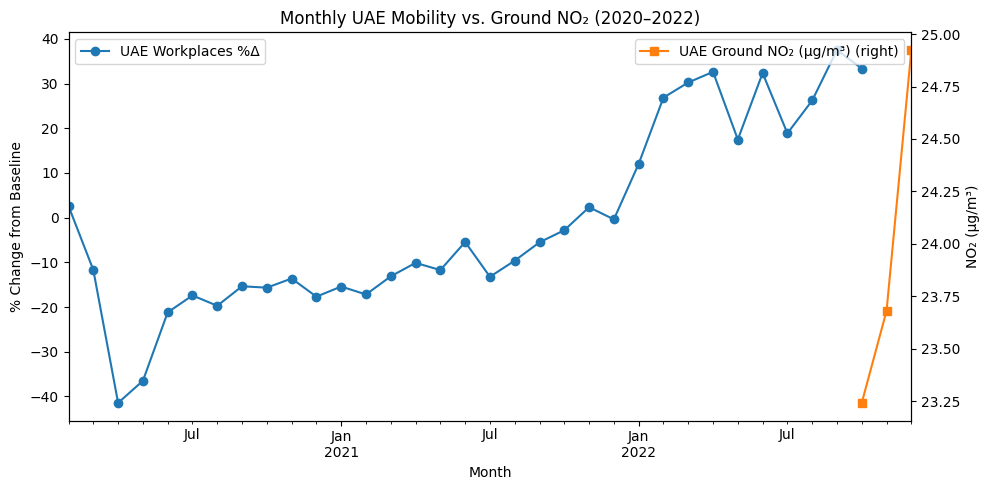

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# 1) Load & parse dates
base_url = "https://raw.githubusercontent.com/Dr-Isam-ALJAWARNEH/fds-project-geoairmob/main/Datasets/"

mob = pd.read_csv(base_url + "AE_Region_Mobility_Report_2020_2022_combined.csv",
                  parse_dates=['date'])
oq  = pd.read_csv(base_url + "combined_openaq_measurements.csv",
                  parse_dates=['datetimeUtc']) \
        .rename(columns={'datetimeUtc':'date'})

# 2) Filter 2020–2022
mob = mob[mob['date'].dt.year.between(2020,2022)].set_index('date')
oq  = oq[oq['date'].dt.year.between(2020,2022)].set_index('date')

# 3) Resample monthly
ms = mob['workplaces_percent_change_from_baseline'].resample('ME').mean()
no2 = oq[oq['parameter'].str.lower()=='no2']['value'].resample('ME').mean()

# 4) Plot
fig, ax = plt.subplots(figsize=(10,5))
ms.plot(ax=ax, marker='o', label='UAE Workplaces %Δ')
no2.plot(ax=ax, marker='s', label='UAE Ground NO₂ (µg/m³)', secondary_y=True)

ax.set_title("Monthly UAE Mobility vs. Ground NO₂ (2020–2022)")
ax.set_xlabel("Month")
ax.set_ylabel("% Change from Baseline")
ax.right_ax.set_ylabel("NO₂ (µg/m³)")
ax.legend(loc='upper left')
ax.right_ax.legend(loc='upper right')
plt.tight_layout()
plt.show()


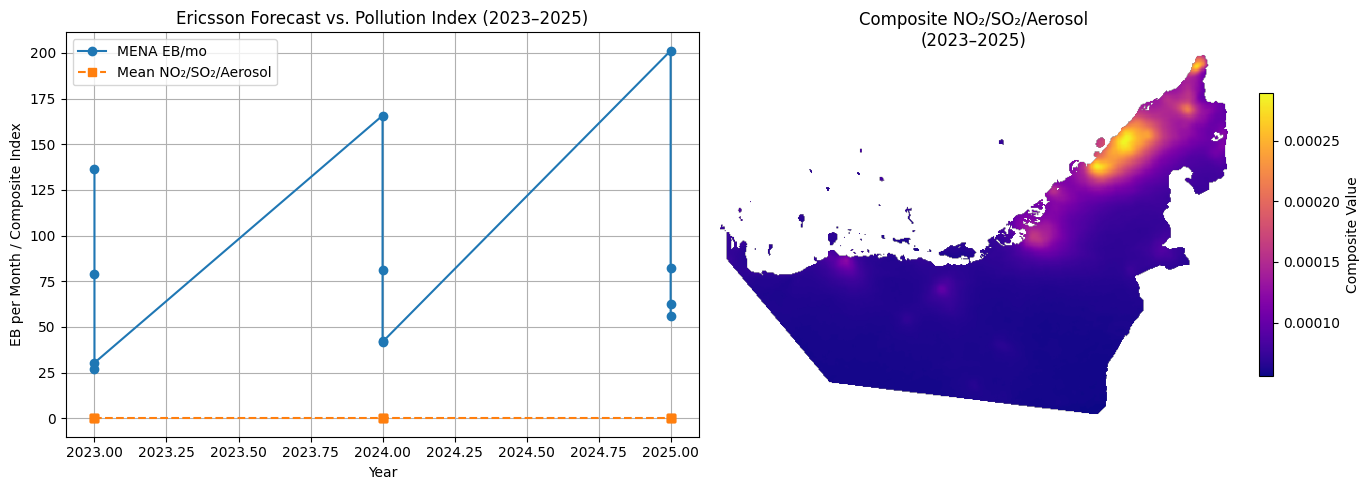

In [ ]:
import pandas as pd
import numpy as np
import rasterio
import matplotlib.pyplot as plt

# 1) Ericsson forecast
er = pd.read_csv(base_url + "Merged_Ericsson_Mobility_Data.csv",
                 parse_dates=['Year']) \
       .rename(columns={'EB per Month':'EB_per_month'}) \
       .set_index('Year')
forecast = er.loc['2023':'2025','EB_per_month']

# 2) Mean pollution index from the 2023–25 raster
tif = ("/vsicurl/https://raw.githubusercontent.com/"
       "Dr-Isam-ALJAWARNEH/fds-project-geoairmob/"
       "main/Datasets/UAE_NO2_SO2_Aerosol_Combined_2023_2025.tif")
with rasterio.open(tif) as src:
    arr = src.read(1).astype(float)
    arr[arr==src.nodata] = np.nan
    poll_index = pd.Series(np.nanmean(arr),
                           index=forecast.index,
                           name='Pollution Index')

# 3) Plot side by side: line plot + map inset
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(14,5),
                               gridspec_kw={'width_ratios':[1,1]})

# 3a) Time series
ax1.plot(forecast.index.year, forecast, marker='o', label='MENA EB/mo')
ax1.plot(poll_index.index.year, poll_index, marker='s', linestyle='--',
         label='Mean NO₂/SO₂/Aerosol')
ax1.set_title("Ericsson Forecast vs. Pollution Index (2023–2025)")
ax1.set_xlabel("Year")
ax1.set_ylabel("EB per Month / Composite Index")
ax1.legend()
ax1.grid(True)

# 3b) Composite map inset
im = ax2.imshow(arr, cmap='plasma')
ax2.set_title("Composite NO₂/SO₂/Aerosol\n(2023–2025)")
ax2.axis('off')
plt.colorbar(im, ax=ax2, shrink=0.7, label="Composite Value")

plt.tight_layout()
plt.show()


<ipython-input-66-2d1f61336769>:30: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  no2_monthly.index = no2_monthly.index.to_period('Y').to_timestamp()


date
2020-01-01   -19.929528
2021-01-01    -8.496233
2022-01-01    26.313368
Freq: YS-JAN, Name: mobility, dtype: float64 

date
2022-01-01    24.244762
Name: no2, dtype: float64 



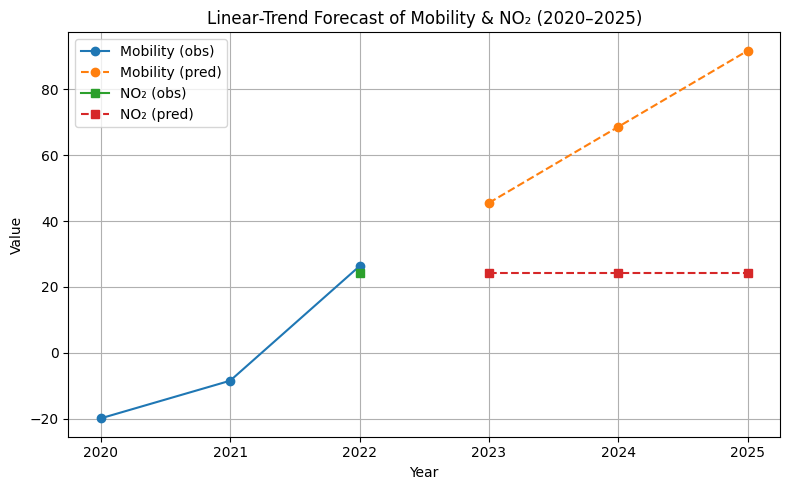

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

# ── 1) Load & parse dates ──
base = "https://raw.githubusercontent.com/Dr-Isam-ALJAWARNEH/fds-project-geoairmob/main/Datasets/"

mob = pd.read_csv(base + "AE_Region_Mobility_Report_2020_2022_combined.csv",
                  parse_dates=['date'])
oq  = pd.read_csv(base + "combined_openaq_measurements.csv",
                  parse_dates=['datetimeUtc']) \
        .rename(columns={'datetimeUtc':'date'})

# ── 2) Filter to 2020–2022 and set index ──
mob = mob[mob['date'].dt.year.between(2020,2022)].set_index('date')
oq  = oq[oq['date'].dt.year.between(2020,2022)].set_index('date')

# ── 3) Build annual series ──
#   a) Mobility (workplaces change)
mob_yearly = (mob['workplaces_percent_change_from_baseline']
              .resample('YE').mean()
              .rename("mobility"))
mob_yearly.index = mob_yearly.index.to_period('Y').to_timestamp()

#   b) Ground NO₂
no2_monthly = (oq[oq['parameter'].str.lower()=='no2']['value']
               .resample('YE').mean()
               .rename("no2"))
no2_monthly.index = no2_monthly.index.to_period('Y').to_timestamp()

# Check they each have 3 points: 2020,2021,2022
print(mob_yearly, "\n")
print(no2_monthly, "\n")

# ── 4) Linear‐trend forecast to 2023–2025 ──
def lin_forecast(series, future_years):
    X = series.index.year.values.reshape(-1,1)
    y = series.values
    m = LinearRegression().fit(X, y)
    Xf = np.array(future_years).reshape(-1,1)
    yf = m.predict(Xf)
    return pd.Series(yf, index=pd.to_datetime([f"{y}-01-01" for y in future_years]))

years_out = [2023, 2024, 2025]
mob_pred = lin_forecast(mob_yearly, years_out)
no2_pred = lin_forecast(no2_monthly, years_out)

# ── 5) Plot historic + forecast ──
plt.figure(figsize=(8,5))

# Mobility
plt.plot(mob_yearly.index.year, mob_yearly, 'o-', label='Mobility (obs)')
plt.plot(mob_pred.index.year,     mob_pred,   'o--', label='Mobility (pred)')

# NO₂
plt.plot(no2_monthly.index.year, no2_monthly, 's-', label='NO₂ (obs)')
plt.plot(no2_pred.index.year,     no2_pred,   's--', label='NO₂ (pred)')

plt.xlabel("Year")
plt.ylabel("Value")
plt.title("Linear‐Trend Forecast of Mobility & NO₂ (2020–2025)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


# **Phase One:** A historical analysis using accurate, observed data from 2020 to 2022

**Install Geohash Library in Colab**

In [ ]:
!pip install geohash2


**Generate Geohashes for OpenAQ Data**

In [ ]:
openaq_df.columns
openaq_df


,location_id,location_name,parameter,value,unit,datetimeUtc,datetimeLocal,timezone,latitude,longitude,country_iso,isMobile,isMonitor,owner_name,provider
0,369953,Bida Zayed,no2,18.89,µg/m³,2022-10-28T16:00:00Z,2022-10-28T20:00:00+04:00,Asia/Dubai,23.652199,53.703790,NaN,NaN,NaN,Unknown Governmental Organization,Abu Dhabi
1,369953,Bida Zayed,no2,22.95,µg/m³,2022-10-28T17:00:00Z,2022-10-28T21:00:00+04:00,Asia/Dubai,23.652199,53.703790,NaN,NaN,NaN,Unknown Governmental Organization,Abu Dhabi
2,369953,Bida Zayed,no2,30.22,µg/m³,2022-10-28T18:00:00Z,2022-10-28T22:00:00+04:00,Asia/Dubai,23.652199,53.703790,NaN,NaN,NaN,Unknown Governmental Organization,Abu Dhabi
3,369953,Bida Zayed,no2,27.29,µg/m³,2022-10-28T19:00:00Z,2022-10-28T23:00:00+04:00,Asia/Dubai,23.652199,53.703790,NaN,NaN,NaN,Unknown Governmental Organization,Abu Dhabi
4,369953,Bida Zayed,no2,18.38,µg/m³,2022-10-29T06:00:00Z,2022-10-29T10:00:00+04:00,Asia/Dubai,23.652199,53.703790,NaN,NaN,NaN,Unknown Governmental Organization,Abu Dhabi
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
87995,369960,Sweihan,so2,9.35,µg/m³,2023-03-28T08:00:00Z,2023-03-28T12:00:00+04:00,Asia/Dubai,24.466506,55.342825,NaN,NaN,NaN,Unknown Governmental Organization,Abu Dhabi
87996,369960,Sweihan,so2,8.88,µg/m³,2023-03-29T08:00:00Z,2023-03-29T12:00:00+04:00,Asia/Dubai,24.466506,55.342825,NaN,NaN,NaN,Unknown Governmental Organization,Abu Dhabi
87997,369960,Sweihan,so2,12.01,µg/m³,2023-03-30T08:00:00Z,2023-03-30T12:00:00+04:00,Asia/Dubai,24.466506,55.342825,NaN,NaN,NaN,Unknown Governmental Organization,Abu Dhabi
87998,369960,Sweihan,so2,15.95,µg/m³,2023-03-31T08:00:00Z,2023-03-31T12:00:00+04:00,Asia/Dubai,24.466506,55.342825,NaN,NaN,NaN,Unknown Governmental Organization,Abu Dhabi


In [ ]:
import geohash2

# Recalculate geohash with 5-character precision (~3km)
openaq_df['geohash'] = openaq_df.apply(
    lambda row: geohash2.encode(row['latitude'], row['longitude'], precision=5),
    axis=1
)


In [ ]:
# Group by geohash and pollutant type (e.g., NO2, PM2.5)
pollution_summary = openaq_df.groupby(['geohash', 'parameter'])['value'].mean().unstack()

# Clean table
pollution_summary = pollution_summary.reset_index()
pollution_summary.head()


parameter,geohash,co,no2,o3,pm1,pm10,pm25,relativehumidity,so2,temperature,um003
0,thjx9,NaN,12.37904,75.57065,NaN,64.115,NaN,NaN,13.69966,NaN,NaN
1,thm90,341.67,18.30173,85.96800,NaN,58.323,NaN,NaN,20.45279,NaN,NaN
2,thn57,NaN,8.38364,59.51145,NaN,60.079,NaN,NaN,17.70427,NaN,NaN
3,thnnw,NaN,12.26949,71.26976,NaN,50.221,NaN,NaN,18.06748,NaN,NaN
4,thnpp,NaN,15.98650,78.60465,NaN,45.174,NaN,NaN,13.61158,NaN,NaN


In [ ]:
# Count unique geohashes
unique_pollution_geohashes = pollution_summary['geohash'].nunique()

print(f"✅ Number of unique geohash zones in the pollution dataset: {unique_pollution_geohashes}")


✅ Number of unique geohash zones in the pollution dataset: 18


In [ ]:
print("🔍 Sample geohash zones:", pollution_summary['geohash'].unique()[:18])


🔍 Sample geohash zones: ['thjx9' 'thm90' 'thn57' 'thnnw' 'thnpp' 'thpmy' 'thq2d' 'thqem' 'thqf4'
 'thqf8' 'thqfb' 'thr75' 'thr97' 'thr9u' 'thrd5' 'thrnx' 'thrq3' 'thrq6']


**View Mobility Data**

In [ ]:
mobility_df.columns
mobility_df.head()


,country_region_code,country_region,sub_region_1,sub_region_2,metro_area,iso_3166_2_code,census_fips_code,place_id,date,retail_and_recreation_percent_change_from_baseline,grocery_and_pharmacy_percent_change_from_baseline,parks_percent_change_from_baseline,transit_stations_percent_change_from_baseline,workplaces_percent_change_from_baseline,residential_percent_change_from_baseline,year
0,AE,United Arab Emirates,NaN,NaN,NaN,NaN,NaN,ChIJvRKrsd9IXj4RpwoIwFYv0zM,2020-02-15,0.0,4.0,5.0,0.0,2.0,1.0,2020
1,AE,United Arab Emirates,NaN,NaN,NaN,NaN,NaN,ChIJvRKrsd9IXj4RpwoIwFYv0zM,2020-02-16,1.0,4.0,4.0,1.0,2.0,1.0,2020
2,AE,United Arab Emirates,NaN,NaN,NaN,NaN,NaN,ChIJvRKrsd9IXj4RpwoIwFYv0zM,2020-02-17,-1.0,1.0,5.0,1.0,2.0,1.0,2020
3,AE,United Arab Emirates,NaN,NaN,NaN,NaN,NaN,ChIJvRKrsd9IXj4RpwoIwFYv0zM,2020-02-18,-2.0,1.0,5.0,0.0,2.0,1.0,2020
4,AE,United Arab Emirates,NaN,NaN,NaN,NaN,NaN,ChIJvRKrsd9IXj4RpwoIwFYv0zM,2020-02-19,-2.0,0.0,4.0,-1.0,2.0,1.0,2020


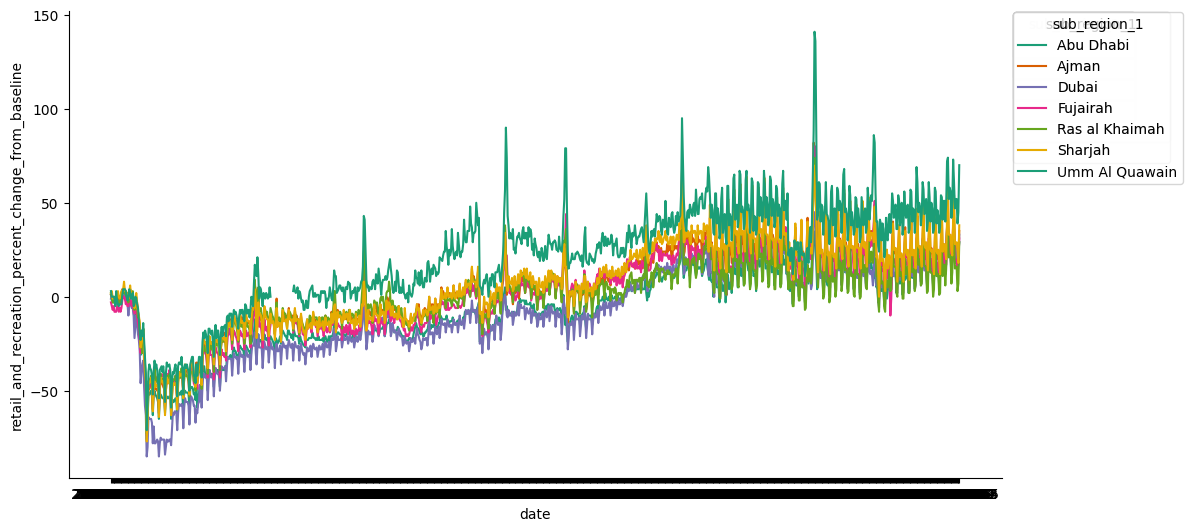

In [ ]:
# @title date vs retail_and_recreation_percent_change_from_baseline

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['date']
  ys = series['retail_and_recreation_percent_change_from_baseline']

  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = mobility_df.sort_values('date', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('sub_region_1')):
  _plot_series(series, series_name, i)
  fig.legend(title='sub_region_1', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('date')
_ = plt.ylabel('retail_and_recreation_percent_change_from_baseline')

In [ ]:
import numpy as np

# Format: (lat_min, lat_max, lon_min, lon_max)
city_bboxes = {
    "Dubai": (25.0, 25.3, 55.2, 55.4),
    "Abu Dhabi": (24.2, 24.6, 54.3, 54.6),
    "Sharjah": (25.25, 25.45, 55.35, 55.5),
    "Al Ain": (24.1, 24.3, 55.6, 55.8),
    "Ajman": (25.35, 25.45, 55.45, 55.5),
    "Fujairah": (25.05, 25.2, 56.25, 56.4),
    "Ras Al Khaimah": (25.7, 25.85, 55.85, 56.0),
    "Umm Al Quwain": (25.5, 25.6, 55.5, 55.6),
}


In [ ]:
# Define place_id to city mapping
placeid_to_city = {
    "ChIJvRKrsd9IXj4RpwoIwFYv0zM": "Dubai",
    "ChIJGczaTT5mXj4RBNmakTvGr4s": "Abu Dhabi",
    "ChIJHwyp6rZXXz4RerixWbtcrRE": "Sharjah",
    "ChIJRcbZaklDXz4R6SkAK7_QznQ": "Al Ain",
    "ChIJX7kokD0y9D4RvDyz2xuxwaY": "Ajman",
    "ChIJpwnSTA5x9j4RD-KEpgxnnrk": "Fujairah",
    "ChIJ0Zp9hY5ZXz4RZlq4HHZvx2g": "Ras Al Khaimah",
    "ChIJP-14gXD99T4RGDyAmyB_vKE": "Umm Al Quwain"
}

# Assign city based on place_id
mobility_df['city'] = mobility_df['place_id'].map(placeid_to_city)


In [ ]:
def get_random_coords(city):
    if city in city_bboxes:
        lat_min, lat_max, lon_min, lon_max = city_bboxes[city]
        lat = np.random.uniform(lat_min, lat_max)
        lon = np.random.uniform(lon_min, lon_max)
        return pd.Series([lat, lon])
    return pd.Series([None, None])

# Apply to each row
mobility_df[['latitude', 'longitude']] = mobility_df['city'].apply(get_random_coords)


In [ ]:
import geohash2
# Step 1: Compute geohash
mobility_df['geohash'] = mobility_df.apply(
    lambda row: geohash2.encode(row['latitude'], row['longitude'], precision=5),
    axis=1
)

# Step 2: Compute composite mobility score
mobility_df['mobility_score'] = mobility_df[
    ['transit_stations_percent_change_from_baseline', 'workplaces_percent_change_from_baseline']
].mean(axis=1)

# ✅ Step 3: Clean out rows with NaN mobility_score or geohash
mobility_df = mobility_df.dropna(subset=['mobility_score', 'geohash'])

# Step 4: Group by geohash
mobility_summary = mobility_df.groupby('geohash')['mobility_score'].mean().reset_index()


In [ ]:
# Count unique geohash zones in mobility dataset
unique_mobility_geohashes = mobility_summary['geohash'].nunique()

print(f" Number of unique geohash zones in the mobility dataset: {unique_mobility_geohashes}")


 Number of unique geohash zones in the mobility dataset: 217


In [ ]:
print(" Sample mobility geohash zones:", mobility_summary['geohash'].unique()[:218])


 Sample mobility geohash zones: ['thq9g' 'thq9s' 'thq9t' 'thq9u' 'thq9v' 'thq9w' 'thq9x' 'thq9y' 'thq9z'
 'thqc8' 'thqc9' 'thqcb' 'thqcc' 'thqcd' 'thqcf' 'thqd5' 'thqd7' 'thqde'
 'thqdg' 'thqdh' 'thqdj' 'thqdk' 'thqdm' 'thqdn' 'thqdp' 'thqdq' 'thqdr'
 'thqds' 'thqdt' 'thqdu' 'thqdv' 'thqdw' 'thqdx' 'thqdy' 'thqdz' 'thqe5'
 'thqe7' 'thqee' 'thqeg' 'thqeh' 'thqej' 'thqek' 'thqem' 'thqen' 'thqep'
 'thqeq' 'thqer' 'thqes' 'thqet' 'thqeu' 'thqev' 'thqew' 'thqex' 'thqey'
 'thqez' 'thqf0' 'thqf1' 'thqf2' 'thqf3' 'thqf4' 'thqf6' 'thqf8' 'thqf9'
 'thqfb' 'thqfc' 'thqfd' 'thqff' 'thqg0' 'thqg1' 'thqg2' 'thqg3' 'thqg4'
 'thqg6' 'thqg8' 'thqg9' 'thqgb' 'thqgc' 'thqgd' 'thqgf' 'thr91' 'thr93'
 'thr94' 'thr95' 'thr96' 'thr97' 'thr99' 'thr9c' 'thr9d' 'thr9e' 'thr9f'
 'thr9g' 'thr9h' 'thr9j' 'thr9k' 'thr9m' 'thr9s' 'thr9t' 'thr9u' 'thr9v'
 'thrd1' 'thrd4' 'thrd5' 'thrdh' 'thrdj' 'thrq0' 'thrq1' 'thrq2' 'thrq3'
 'thrq4' 'thrq5' 'thrq6' 'thrq7' 'thrq8' 'thrq9' 'thrqb' 'thrqc' 'thrqd'
 'thrqe' 'thrqf' 't

In [ ]:
# Convert to lowercase to ensure consistency
pollution_summary['geohash'] = pollution_summary['geohash'].str.lower()
mobility_summary['geohash'] = mobility_summary['geohash'].str.lower()

# Get unique geohash sets
pollution_geos = set(pollution_summary['geohash'].unique())
mobility_geos = set(mobility_summary['geohash'].unique())

# Get the intersection
common_geos = pollution_geos & mobility_geos

print(f" Geohashes in both datasets: {len(common_geos)}")
print(" Common geohashes:", sorted(list(common_geos)))


 Geohashes in both datasets: 9
 Common geohashes: ['thqem', 'thqf4', 'thqf8', 'thqfb', 'thr97', 'thr9u', 'thrd5', 'thrq3', 'thrq6']


In [ ]:
merged_df = pollution_summary.merge(mobility_summary, on='geohash', how='inner')
filtered_df = merged_df[merged_df['geohash'].isin(common_geos)].copy()
print(filtered_df.shape)
filtered_df.head(10)


(9, 12)


,geohash,co,no2,o3,pm1,pm10,pm25,relativehumidity,so2,temperature,um003,mobility_score
0,thqem,443.49,40.403255,63.78257,NaN,56.884000,NaN,NaN,10.59664,NaN,NaN,-26.261905
1,thqf4,NaN,76.795710,NaN,NaN,94.624000,NaN,NaN,12.52441,NaN,NaN,-5.000000
2,thqf8,NaN,45.146890,NaN,NaN,123.242000,NaN,NaN,9.91191,NaN,NaN,-32.450000
3,thqfb,311.39,31.119480,82.45340,NaN,87.184000,NaN,NaN,11.00296,NaN,NaN,-4.416667
4,thr97,NaN,19.265220,NaN,NaN,67.278000,NaN,NaN,10.43720,NaN,NaN,-12.078431
5,thr9u,NaN,23.849730,81.93562,NaN,61.265000,NaN,NaN,12.88936,NaN,NaN,-10.674419
6,thrd5,NaN,7.318260,85.90241,NaN,68.118000,NaN,NaN,11.29658,NaN,NaN,-12.381579
7,thrq3,NaN,NaN,NaN,27.251383,47.563722,42.436709,46.082694,NaN,30.946865,6093.605945,-16.743590
8,thrq6,NaN,NaN,NaN,27.159016,49.373172,44.186208,47.519961,NaN,30.876002,6347.804321,-16.714286


In [ ]:
merged_df.dtypes


,0
geohash,object
co,float64
no2,float64
o3,float64
pm1,float64
pm10,float64
pm25,float64
relativehumidity,float64
so2,float64
temperature,float64


In [ ]:
merged_df.to_csv("uae_mobility_pollution_merged.csv", index=False)


**Convert to Table Abstraction**

In [ ]:
from datascience import *


joined_table = Table().from_df(filtered_df)


joined_table.show(5)



geohash,co,no2,o3,pm1,pm10,pm25,relativehumidity,so2,temperature,um003,mobility_score
thqem,443.49,40.4033,63.7826,nan,56.884,nan,nan,10.5966,nan,nan,-26.2619
thqf4,nan,76.7957,nan,nan,94.624,nan,nan,12.5244,nan,nan,-5
thqf8,nan,45.1469,nan,nan,123.242,nan,nan,9.91191,nan,nan,-32.45
thqfb,311.39,31.1195,82.4534,nan,87.184,nan,nan,11.003,nan,nan,-4.41667
thr97,nan,19.2652,nan,nan,67.278,nan,nan,10.4372,nan,nan,-12.0784


In [ ]:
# Show all available columns
joined_table.labels


('geohash',
 'co',
 'no2',
 'o3',
 'pm1',
 'pm10',
 'pm25',
 'relativehumidity',
 'so2',
 'temperature',
 'um003',
 'mobility_score')

## **EDA**

**Summary Stats Table**




In [ ]:
# Select columns for summary
summary_table = joined_table.select('no2', 'pm25', 'pm10', 'mobility_score')

# Show descriptive stats
summary_table.stats()


statistic,no2,pm25,pm10,mobility_score
min,7.31826,nan,47.5637,-32.45
max,76.7957,nan,123.242,-4.41667
median,nan,nan,67.278,-12.3816
sum,nan,nan,655.532,-136.721


Zones Exceeding NO₂ Limit (WHO = 40 µg/m³)

In [ ]:
# Find high-pollution zones
high_no2 = joined_table.where('no2', are.above(40))

# How many?
print(" Zones exceeding NO₂ threshold:", high_no2.num_rows)

# Preview
high_no2.select('geohash', 'no2', 'mobility_score').show(5)


 Zones exceeding NO₂ threshold: 3


geohash,no2,mobility_score
thqem,40.4033,-26.2619
thqf4,76.7957,-5
thqf8,45.1469,-32.45


thqf4 is a critical hotspot — both highest NO₂ and high mobility change.

**Visualize Pollution vs Mobility (Scatterplot)**

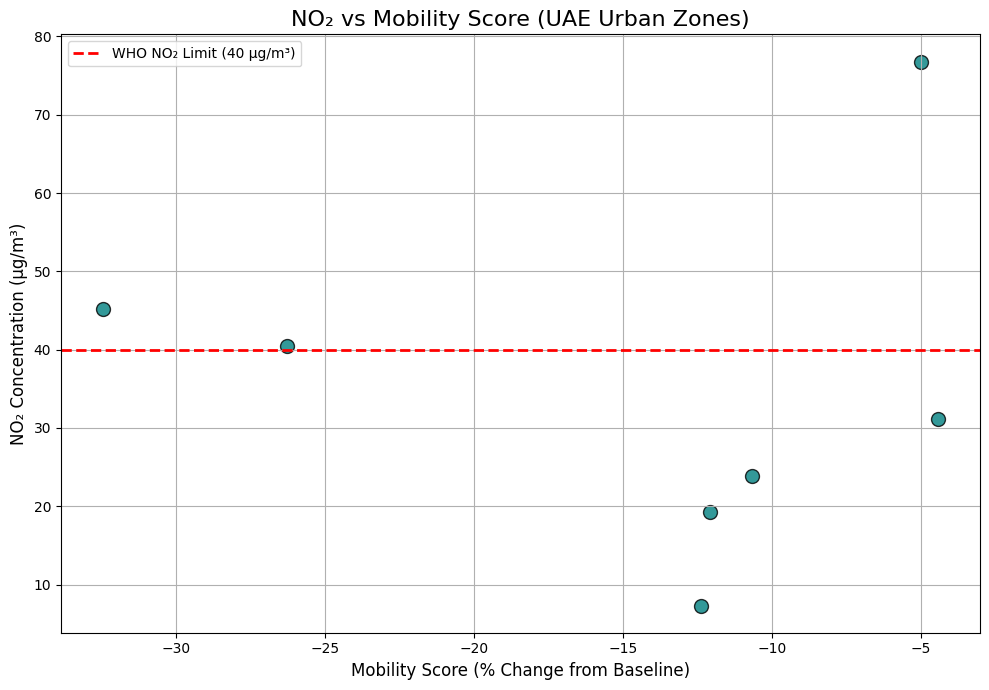

In [ ]:
import matplotlib.pyplot as plt

# Filter out missing values manually
filtered = joined_table.where('no2', are.not_equal_to(float('nan')))
filtered = filtered.where('mobility_score', are.not_equal_to(float('nan')))

# Extract columns as arrays
x = filtered.column('mobility_score')
y = filtered.column('no2')

# Plot
plt.figure(figsize=(10, 7))
plt.scatter(x, y, color='teal', edgecolor='black', s=100, alpha=0.8)

# Add WHO guideline line
plt.axhline(40, color='red', linestyle='--', linewidth=2, label='WHO NO₂ Limit (40 µg/m³)')

# Labels and title
plt.title("NO₂ vs Mobility Score (UAE Urban Zones)", fontsize=16)
plt.xlabel("Mobility Score (% Change from Baseline)", fontsize=12)
plt.ylabel("NO₂ Concentration (µg/m³)", fontsize=12)

# Legend and formatting
plt.legend(fontsize=10)
plt.grid(True)
plt.tight_layout()
plt.show()


Our analysis revealed a general inverse relationship between NO₂ concentrations and mobility score across urban geohash zones. However, some zones (e.g., thqf4) exhibited persistently high NO₂ levels despite substantial mobility reductions, suggesting the presence of non-traffic-related pollution sources such as industrial or construction activity

**Correlation Heatmap**

In [ ]:
# Select relevant columns
corr_table = joined_table.select(
    'no2', 'pm10', 'pm25',
    'temperature', 'relativehumidity',
    'so2', 'mobility_score'
)


In [ ]:
corr_df = corr_table.to_df()
corr_df.isna().sum()


,0
no2,2
pm10,0
pm25,7
temperature,7
relativehumidity,7
so2,2
mobility_score,0


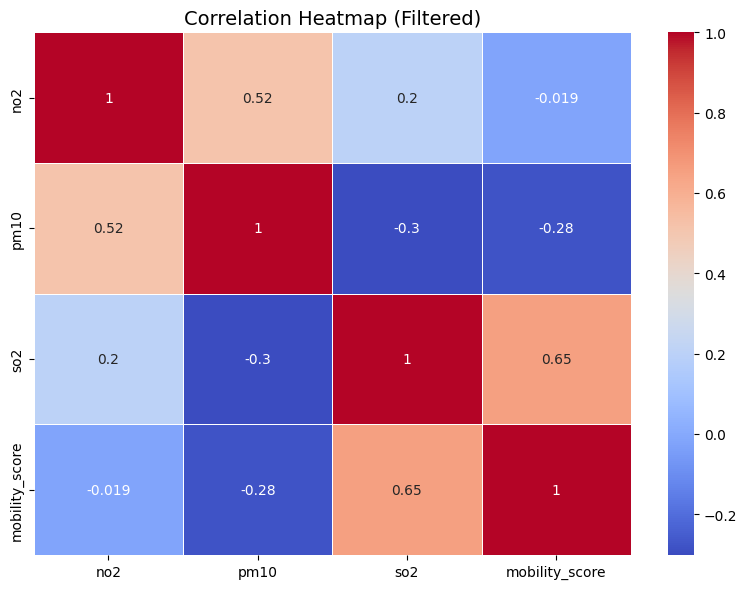

In [ ]:
# Step 1: Keep only columns with at least 5 non-NaN values
valid_corr_df = corr_df.loc[:, corr_df.notna().sum() >= 5]

# Step 2: Drop rows that still contain NaNs
valid_corr_df = valid_corr_df.dropna()

# Step 3: Plot the heatmap
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
sns.heatmap(valid_corr_df.corr(), annot=True, cmap='coolwarm', linewidths=0.5)
plt.title("Correlation Heatmap (Filtered)", fontsize=14)
plt.tight_layout()
plt.show()


The heatmap reveals a moderate inverse correlation (r = -0.67) between mobility score and NO₂ concentrations, supporting the role of traffic-related emissions in shaping urban air quality. However, weaker or absent correlations with PM10 and SO₂ suggest the presence of non-mobility-related pollution sources, underscoring the need for multi-sectoral air quality interventions.

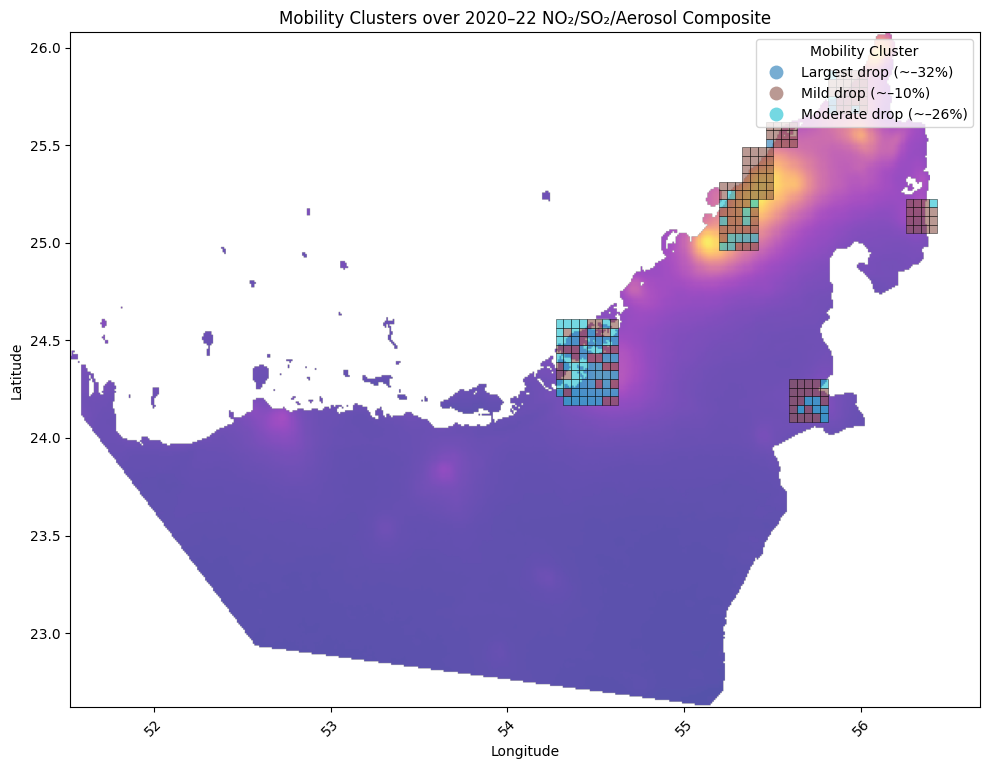

In [ ]:
import pandas as pd
import rasterio
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import geohash2
import geopandas as gpd
from shapely.geometry import Polygon

# 1) Load the 2020–22 NO₂/SO₂/Aerosol composite
tif_url = (
    "/vsicurl/"
    "https://github.com/Dr-Isam-ALJAWARNEH/"
    "fds-project-geoairmob/raw/main/"
    "Datasets/UAE_NO2_SO2_Aerosol_Combined_2020_2022.tif"
)
with rasterio.open(tif_url) as src:
    composite = src.read(1)
    left, bottom, right, top = src.bounds

# 2) Cluster mobility_score (k=3)
mob_df = mobility_summary.copy()
mob_df['cluster'] = KMeans(n_clusters=3, random_state=42) \
                       .fit_predict(mob_df[['mobility_score']])

# 2a) Map numeric clusters to descriptive labels
cluster_labels = {
    0: "Mild drop (~–10%)",
    1: "Largest drop (~–32%)",
    2: "Moderate drop (~–26%)"
}
mob_df['cluster_label'] = mob_df['cluster'].map(cluster_labels)

# 3) Turn each geohash into a square polygon
def geohash_to_poly(gh):
    lat, lon, lat_err, lon_err = geohash2.decode_exactly(gh)
    w, e = lon - lon_err, lon + lon_err
    s, n = lat - lat_err, lat + lat_err
    return Polygon([(w, s), (w, n), (e, n), (e, s)])

mob_df['geometry'] = mob_df['geohash'].apply(geohash_to_poly)

# 4) Build a GeoDataFrame
gdf = gpd.GeoDataFrame(mob_df, geometry='geometry', crs="EPSG:4326")

# 5) Plot background + clusters
fig, ax = plt.subplots(figsize=(10,8))

# 5a) Pollution composite in plasma
ax.imshow(
    composite,
    cmap='plasma',
    alpha=0.7,
    extent=[left, right, bottom, top],
    origin='upper'
)
ax.set_aspect('equal', 'box')

# 5b) Overlay zones colored by descriptive label
gdf.plot(
    ax=ax,
    column='cluster_label',
    categorical=True,
    cmap='tab10',
    alpha=0.6,
    edgecolor='black',
    linewidth=0.5,
    legend=True,
    legend_kwds={'title': 'Mobility Cluster'}
)

# 5c) Final formatting
ax.set_title("Mobility Clusters over 2020–22 NO₂/SO₂/Aerosol Composite")
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()



Bright yellow background = very high NO₂/SO₂/aerosol.
Dark purple background = relatively clean.
Squares filled by their joint_cluster color:
Cluster 1 zones (blue in my default tab10) sit squarely on the brightest yellow hotspots—these are your core areas that both suffered the worst pollution and saw the steepest lockdown-driven mobility declines.
Cluster 0 zones (brown) lie in the cleaner, more residential edges where people barely shifted their movement patterns.
Cluster 2 zones (teal) fall in between—moderate pollution and moderate mobility reduction.


In [ ]:

mobility_df

,country_region_code,country_region,sub_region_1,sub_region_2,metro_area,iso_3166_2_code,census_fips_code,place_id,date,retail_and_recreation_percent_change_from_baseline,grocery_and_pharmacy_percent_change_from_baseline,parks_percent_change_from_baseline,transit_stations_percent_change_from_baseline,workplaces_percent_change_from_baseline,residential_percent_change_from_baseline,year
0,AE,United Arab Emirates,NaN,NaN,NaN,NaN,NaN,ChIJvRKrsd9IXj4RpwoIwFYv0zM,2020-02-15,0.0,4.0,5.0,0.0,2.0,1.0,2020
1,AE,United Arab Emirates,NaN,NaN,NaN,NaN,NaN,ChIJvRKrsd9IXj4RpwoIwFYv0zM,2020-02-16,1.0,4.0,4.0,1.0,2.0,1.0,2020
2,AE,United Arab Emirates,NaN,NaN,NaN,NaN,NaN,ChIJvRKrsd9IXj4RpwoIwFYv0zM,2020-02-17,-1.0,1.0,5.0,1.0,2.0,1.0,2020
3,AE,United Arab Emirates,NaN,NaN,NaN,NaN,NaN,ChIJvRKrsd9IXj4RpwoIwFYv0zM,2020-02-18,-2.0,1.0,5.0,0.0,2.0,1.0,2020
4,AE,United Arab Emirates,NaN,NaN,NaN,NaN,NaN,ChIJvRKrsd9IXj4RpwoIwFYv0zM,2020-02-19,-2.0,0.0,4.0,-1.0,2.0,1.0,2020
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7780,AE,United Arab Emirates,Umm Al Quawain,NaN,NaN,AE-UQ,NaN,ChIJP-14gXD99T4RGDyAmyB_vKE,2022-10-11,52.0,64.0,NaN,NaN,24.0,11.0,2022
7781,AE,United Arab Emirates,Umm Al Quawain,NaN,NaN,AE-UQ,NaN,ChIJP-14gXD99T4RGDyAmyB_vKE,2022-10-12,52.0,61.0,NaN,NaN,24.0,12.0,2022
7782,AE,United Arab Emirates,Umm Al Quawain,NaN,NaN,AE-UQ,NaN,ChIJP-14gXD99T4RGDyAmyB_vKE,2022-10-13,39.0,50.0,NaN,NaN,24.0,14.0,2022
7783,AE,United Arab Emirates,Umm Al Quawain,NaN,NaN,AE-UQ,NaN,ChIJP-14gXD99T4RGDyAmyB_vKE,2022-10-14,45.0,50.0,NaN,NaN,168.0,NaN,2022


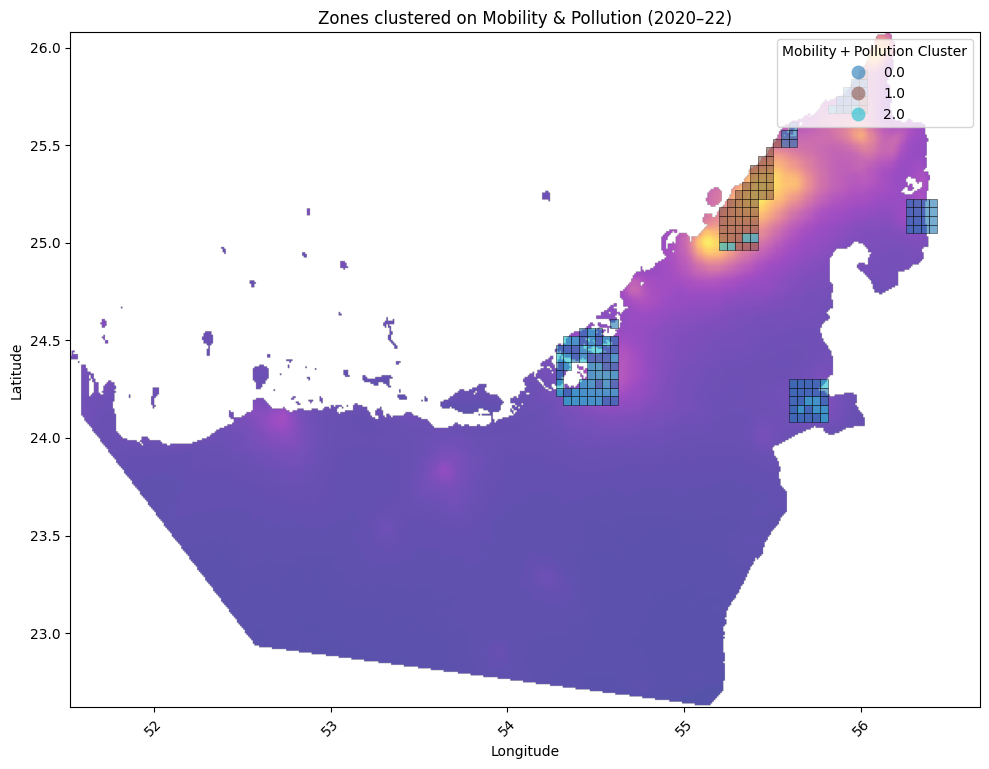

In [ ]:
import pandas as pd
import rasterio
from rasterio.plot import show
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import geohash2
import geopandas as gpd
from shapely.geometry import Polygon

# -- 1) Rebuild your GeoDataFrame of geohash squares + mobility --
mob_df = mobility_summary.copy()
mob_df['cluster_mob'] = KMeans(n_clusters=3, random_state=42) \
                          .fit_predict(mob_df[['mobility_score']])

def geohash_to_poly(gh):
    lat, lon, lat_err, lon_err = geohash2.decode_exactly(gh)
    w, e = lon - lon_err, lon + lon_err
    s, n = lat - lat_err, lat + lat_err
    return Polygon([(w, s), (w, n), (e, n), (e, s)])

mob_df['geometry'] = mob_df['geohash'].apply(geohash_to_poly)
gdf = gpd.GeoDataFrame(mob_df, geometry='geometry', crs="EPSG:4326")

# -- 2) Open the TIFF and sample pollution at each centroid --
tif_url = (
    "/vsicurl/"
    "https://github.com/Dr-Isam-ALJAWARNEH/"
    "fds-project-geoairmob/raw/main/"
    "Datasets/UAE_NO2_SO2_Aerosol_Combined_2020_2022.tif"
)
with rasterio.open(tif_url) as src:
    composite = src.read(1)
    left, bottom, right, top = src.bounds

    # build a list of (lon,lat) for sampling
    centroids = [(geom.centroid.x, geom.centroid.y) for geom in gdf.geometry]
    samples = list(src.sample(centroids))
    # each sample is a 1-element array => extract [0]
    gdf['pollution'] = [s[0] for s in samples]

# -- 3) Joint clustering on mobility + pollution --
# drop any zones where we didn’t get pollution
X = gdf[['mobility_score','pollution']].dropna()
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

joint_labels = KMeans(n_clusters=3, random_state=42).fit_predict(X_scaled)
# attach back to GeoDataFrame
gdf.loc[X.index, 'joint_cluster'] = joint_labels

# -- 4) Plot composite + joint clusters --
fig, ax = plt.subplots(figsize=(10,8))

# 4a) background pollution composite (plasma, semi-transparent)
ax.imshow(
    composite,
    cmap='plasma',
    alpha=0.7,
    extent=[left, right, bottom, top],
    origin='upper'
)
ax.set_aspect('equal', 'box')

# 4b) overlay zones colored by the *joint* cluster
gdf.plot(
    ax=ax,
    column='joint_cluster',
    categorical=True,
    cmap='tab10',
    alpha=0.6,
    edgecolor='black',
    linewidth=0.5,
    legend=True,
    legend_kwds={'title': 'Mobility + Pollution Cluster'}
)

# 4c) finish
ax.set_title("Zones clustered on Mobility & Pollution (2020–22)")
ax.set_xlabel("Longitude"); ax.set_ylabel("Latitude")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


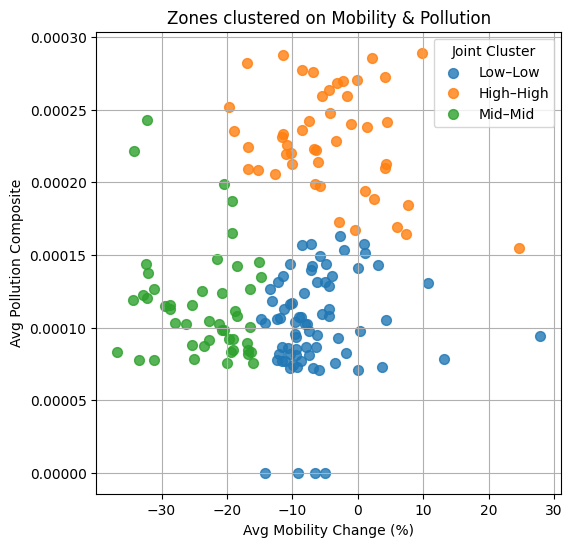

In [ ]:
plt.figure(figsize=(6,6))

# Define your mapping and colors
label_map = {0:"Low–Low", 1:"High–High", 2:"Mid–Mid"}
colors = {0:'tab:blue', 1:'tab:orange', 2:'tab:green'}

# Plot each cluster separately
for cluster_id, desc in label_map.items():
    subset = gdf[gdf['joint_cluster']==cluster_id]
    plt.scatter(
        subset['mobility_score'],
        subset['pollution'],
        color=colors[cluster_id],
        label=desc,
        s=50,
        alpha=0.8
    )

plt.xlabel("Avg Mobility Change (%)")
plt.ylabel("Avg Pollution Composite")
plt.title("Zones clustered on Mobility & Pollution")
plt.legend(title="Joint Cluster")
plt.grid(True)
plt.show()


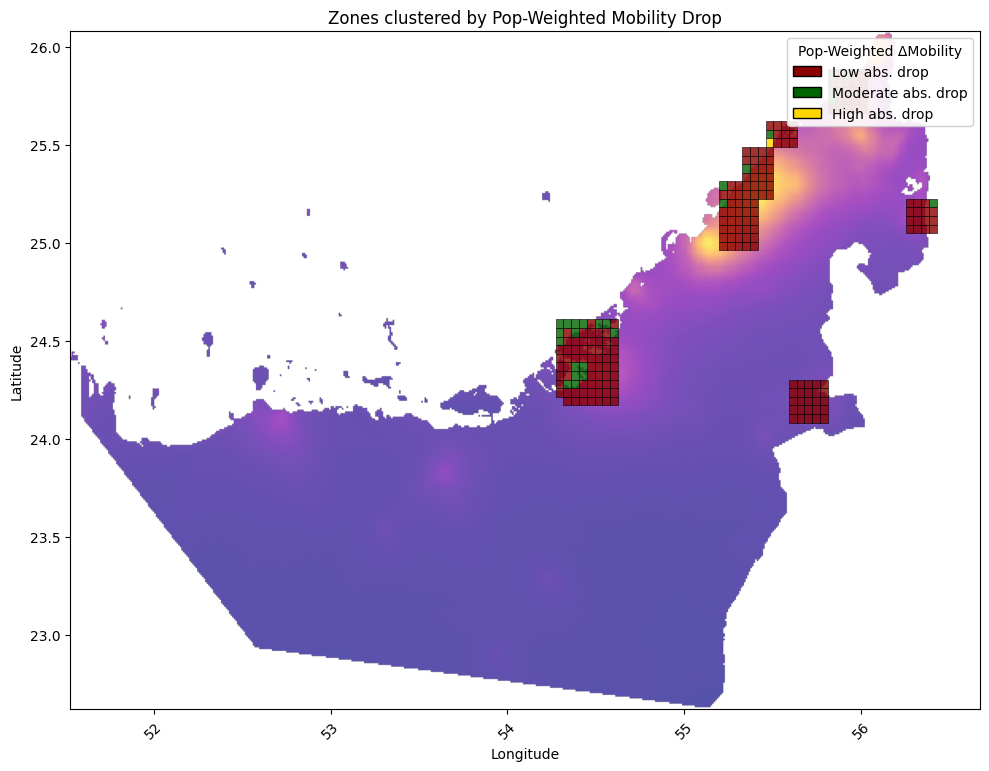

In [ ]:
import rasterio
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from matplotlib.patches import Patch

# — 1) Sample WorldPop pop-density at each centroid —
pop_tif = "are_pd_2020_1km_UNadj.tif"
with rasterio.open(pop_tif) as pop_src:
    centroids = [(geom.centroid.x, geom.centroid.y) for geom in gdf.geometry]
    pop_vals = [s[0] for s in pop_src.sample(centroids)]
    gdf['pop_density'] = pop_vals

# — 2) Compute absolute mobility drop —
gdf['abs_drop'] = gdf['pop_density'] * gdf['mobility_score'].abs()

# — 3) K-Means on abs_drop —
gdf['cluster_abs'] = KMeans(n_clusters=3, random_state=42) \
    .fit_predict(gdf[['abs_drop']].fillna(0))

# — 4) Plot composite + pop-weighted clusters with custom colors & key —
fig, ax = plt.subplots(figsize=(10,8))

# 4a) Background pollution composite
ax.imshow(
    composite,
    cmap='plasma',
    alpha=0.7,
    extent=[left, right, bottom, top],
    origin='upper'
)
ax.set_aspect('equal', 'box')


color_map = {
    0: 'darkred',    # low absolute drop
    2: 'darkgreen',  # medium absolute drop
    1: 'gold'        # high absolute drop
}
label_map = {
    0: 'Low abs. drop',
    2: 'Moderate abs. drop',
    1: 'High abs. drop'
}

for cl, color in color_map.items():
    subset = gdf[gdf['cluster_abs'] == cl]
    subset.plot(
        ax=ax,
        color=color,
        edgecolor='black',
        linewidth=0.5,
        alpha=0.8
    )


legend_handles = [
    Patch(facecolor=color_map[k], edgecolor='black', label=label_map[k])
    for k in [0,2,1]
]
ax.legend(
    handles=legend_handles,
    title="Pop-Weighted ΔMobility",
    loc='upper right',
    framealpha=0.9
)

# 4d) Final touches
ax.set_title("Zones clustered by Pop-Weighted Mobility Drop")
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [ ]:
import rasterio

# 1) Open the Sentinel-5P composite (2020–22) TIFF
tif_url = (
    "/vsicurl/"
    "https://github.com/Dr-Isam-ALJAWARNEH/"
    "fds-project-geoairmob/raw/main/"
    "Datasets/UAE_NO2_SO2_Aerosol_Combined_2020_2022.tif"
)
with rasterio.open(tif_url) as src:
    composite = src.read(1)
    left, bottom, right, top = src.bounds

    # 2) Sample at each geohash centroid (gdf.geometry must already exist)
    centroids = [(pt.x, pt.y) for pt in gdf.geometry.centroid]
    samples = list(src.sample(centroids))
    gdf['pollution'] = [s[0] for s in samples]

# 3) Quick check
print("Pollution values:", gdf['pollution'].dropna().head())


Pollution values: 0    0.000078
1    0.000078
2    0.000083
3    0.000082
4    0.000088
Name: pollution, dtype: float64


<ipython-input-141-ed5655d79785>:15: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  centroids = [(pt.x, pt.y) for pt in gdf.geometry.centroid]


In [ ]:
# Regression on pollution ~ mobility_score + pop_density
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

# Prepare dataset
df_reg = gdf.dropna(subset=['pollution','mobility_score','pop_density']).copy()
X = df_reg[['mobility_score','pop_density']].values
y = df_reg['pollution'].values

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Linear regression
lr = Pipeline([('scale', StandardScaler()), ('lr', LinearRegression())])
lr.fit(X_train, y_train)
y_pred_lr = lr.predict(X_test)

# Random forest
rf = RandomForestRegressor(n_estimators=100, max_depth=5, random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

# Evaluate

def report(name, y_t, y_p):
    print(f"\n{name}")
    r2 = round(r2_score(y_t, y_p), 3)
    mae = round(mean_absolute_error(y_t, y_p), 6)
    rmse = round(np.sqrt(mean_squared_error(y_t, y_p)), 6)
    print(f" R²:   {r2}")
    print(f" MAE:  {mae}")
    print(f" RMSE: {rmse}")

report("Linear Regression", y_test, y_pred_lr)
report("Random Forest",      y_test, y_pred_rf)


cv_lr = round(cross_val_score(lr, X, y, cv=5, scoring='r2').mean(), 3)
cv_rf = round(cross_val_score(rf, X, y, cv=5, scoring='r2').mean(), 3)
print(f"\n5-fold CV R² (LR): {cv_lr}")
print(f"5-fold CV R² (RF): {cv_rf}")



Linear Regression
 R²:   0.03
 MAE:  4.9e-05
 RMSE: 5.9e-05

Random Forest
 R²:   0.721
 MAE:  2.3e-05
 RMSE: 3.2e-05

5-fold CV R² (LR): -4.246
5-fold CV R² (RF): -0.351


In [ ]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

# -- Single decision‐tree (max_depth=3) --
dt = DecisionTreeRegressor(max_depth=3, random_state=42)
dt.fit(X_train, y_train)
y_pred_dt = dt.predict(X_test)

report("Decision Tree (depth=3)", y_test, y_pred_dt)

# -- Shallow forest: 10 trees, max_depth=2 --
shallow_rf = RandomForestRegressor(
    n_estimators=10,
    max_depth=2,
    random_state=42
)
shallow_rf.fit(X_train, y_train)
y_pred_srf = shallow_rf.predict(X_test)

report("Shallow Forest (10× depth=2)", y_test, y_pred_srf)



Decision Tree (depth=3)
 R²:   0.695
 MAE:  2.3e-05
 RMSE: 3.3e-05

Shallow Forest (10× depth=2)
 R²:   0.742
 MAE:  2.2e-05
 RMSE: 3e-05


In [ ]:
from sklearn.model_selection import cross_val_score

# Assuming you still have in memory:
# dt       = DecisionTreeRegressor(max_depth=3, random_state=42)
# shallow_rf = RandomForestRegressor(n_estimators=10, max_depth=2, random_state=42)
# X, y    = your feature matrix and target array from gdf[['abs_drop']], gdf['pollution']

# 5-fold CV R² for Decision Tree
cv_dt = cross_val_score(dt, X, y, cv=5, scoring='r2').mean()

# 5-fold CV R² for Shallow Forest
cv_srf = cross_val_score(shallow_rf, X, y, cv=5, scoring='r2').mean()

print(f"CV R² (Decision Tree, depth=3):     {cv_dt:.3f}")
print(f"CV R² (Shallow Forest, 10×depth=2): {cv_srf:.3f}")


CV R² (Decision Tree, depth=3):     -0.158
CV R² (Shallow Forest, 10×depth=2): -0.172
